Here we import relevant packages. Note that we are using PyTorch for now.

In [0]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

This notebook is set up in Google Drive. As a result, we need to mount the directory path to our Google account.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


This is where we set up our data. Note that we have split the data to 80% training and 20% validation.

In [9]:
# this is to preprocess our images before we run it through a neural network
transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # these are subject to change
])

root = "/content/drive/My Drive/Guitar Dataset/Workflow/Official Dataset"
full_set = datasets.ImageFolder(root=root, transform=transform)
train_size = int(0.8 * len(full_set))
test_size = len(full_set) - train_size
train_set, test_set = torch.utils.data.random_split(full_set, [train_size, test_size])

dataset_sizes = {'train': len(train_set),
                 'test': len(test_set)
                }
dataloaders = {'train': torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=0),
               'test': torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=0)
              }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = full_set.classes
print (class_names)


['C', 'D', 'Em', 'F', 'G']


Given the model, this function performs training 

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('=' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):  # track history if only in train
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

This is where we set up our model. Note that we are performing transfer learning from ResNet18, where we freeze the last layer. \\
Some additional notes:


*   Criterion: CrossEntropyLoss
*   Optimizer: SGD
*   Decaying learning rate



In [5]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5) 

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.3MB/s]


Here is where we actually do the training.

In [6]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
train Loss: 2.4856 Acc: 0.2534
test Loss: 3.0344 Acc: 0.2838

Epoch 1/24
train Loss: 2.9106 Acc: 0.2466
test Loss: 1.9370 Acc: 0.2027

Epoch 2/24
train Loss: 2.5324 Acc: 0.2466
test Loss: 3.6794 Acc: 0.2703

Epoch 3/24
train Loss: 2.6589 Acc: 0.2365
test Loss: 1.9388 Acc: 0.2703

Epoch 4/24
train Loss: 2.4460 Acc: 0.2196
test Loss: 2.9966 Acc: 0.2432

Epoch 5/24
train Loss: 2.6691 Acc: 0.2736
test Loss: 2.1760 Acc: 0.2162

Epoch 6/24
train Loss: 2.3945 Acc: 0.2601
test Loss: 2.8463 Acc: 0.4054

Epoch 7/24
train Loss: 1.7211 Acc: 0.3277
test Loss: 1.5290 Acc: 0.2838

Epoch 8/24
train Loss: 1.5939 Acc: 0.2939
test Loss: 1.4470 Acc: 0.4595

Epoch 9/24
train Loss: 1.5530 Acc: 0.3142
test Loss: 1.8718 Acc: 0.2027

Epoch 10/24
train Loss: 1.6240 Acc: 0.2736
test Loss: 1.5099 Acc: 0.3378

Epoch 11/24
train Loss: 1.5830 Acc: 0.2973
test Loss: 1.6384 Acc: 0.2838

Epoch 12/24
train Loss: 1.5738 Acc: 0.3041
test Loss: 1.7024 Acc: 0.3108

Epoch 13/24
train Loss: 1.6124 Acc: 0.2736
test 

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

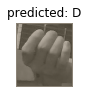

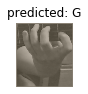

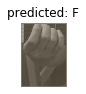

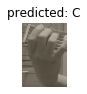

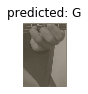

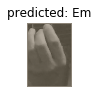

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()